# Stochastic Gradient Descent and Regularization

## Use the code for MNIST Images using CNNs and perform the following tasks



1.   Use Gradient Descent and Stochastic Gradient Descent (SGD) as the learning algorithms and compare the performance for 100 epochs of training. Plot the Loss vs Epochs on the same graph
2.   Using SGD for the same example do the following and comapre the results for each case with the base case done in using SGD in part 1

>
          1.   Train your network using SGD with momentum = 0.9
          2.   Train your network using SGD with Dropout
          3.   Train your network using SGD with L2 regularization 
          
   You should be able to compare the training and test performance for all the three cases with the base case.



In [1]:
#packages used in previous labs
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch import autograd, nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, SubsetRandomSampler #to subset the dataset
from torchvision import transforms, datasets
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline
import time

## 1.1 Define the GD parameters

In [2]:
#parameters for GD
num_epochs = 100
num_classes = 10
sample_size=100  #slower with larger sample_size
batch_size = sample_size
learning_rate = 0.01 #arbituary

#Download the MNIST Train and Test set (Lab1)
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
cuda = torch.cuda.is_available()

#setting a seed to compare answer with TA
torch.manual_seed(1)

#set the arguments
dataloader_args = dict(shuffle=False, batch_size=batch_size,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=False, batch_size=batch_size)
#load the train and test data as DataLoader objects
train_loader = dataloader.DataLoader(train, **dataloader_args,
                                    sampler= SubsetRandomSampler(np.random.RandomState(seed=0).randint(0,len(train)-1,sample_size).tolist())
                                    ) 
test_loader = dataloader.DataLoader(test, **dataloader_args)

### Define the model without Dropout

In [3]:
class ConvNetWOD(nn.Module):  #inherit from the nn.Module super class 
        def __init__(self):
            super(ConvNetWOD, self).__init__() 
            #create some sequential layer objects within the class _init_ function
            self.layer1 = nn.Sequential(    
                #create sequentially ordered layers ( a convolution + ReLU + pooling )
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  #create a set of convolutional filters
                nn.ReLU(),  #ReLU activation
                nn.MaxPool2d(kernel_size=2, stride=2)  #downsample; padding argument defaults to 0
            )
            self.layer2 = nn.Sequential(
                #difference from layer1: he input into the Conv2d function is 32 channels, with an output of 64 channels
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)  )
            #self.drop_out = nn.Dropout() #a drop-out layer to avoid over-fitting
            
            #Create 2 fully connected layers
                #The first argument to this method is the number of nodes in the layer
                #The second argument is the number of nodes in the following layer
            self.fc1 = nn.Linear(7 * 7 * 64, 1000) # 7 x 7 x 64 nodes; connect to the second layer of 1000 nodes
            self.fc2 = nn.Linear(1000, 10)

        #override the base forward function in nn.Module
            #x is the data that is to be passed through the model (i.e. a batch of data)
            #out is the output of each layer
        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)
            #out = self.drop_out(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return

### Implement and train the model using GD without dropout

In [4]:
model0 = ConvNetWOD() #an instance of our ConvNetWOD class

#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss() #it combines both a SoftMax activation and a cross entropy loss function
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)
                            #The first argument is the parameters we want the optimizer to train.
    
#the training loop
total_step = len(train_loader)
loss_list0 = []
acc_list0 = []
for epoch in range(num_epochs):   #iterate over epochs
    for i, (images, labels) in enumerate(train_loader): #iterate over train_loader in each epoch
        # Run the forward pass
        outputs = model0(images) #images is a batch of normalized MNIST images from train_loader
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())

        # perform back-propagation and optimization
        optimizer.zero_grad()  #make the initial gradients zero
        loss.backward()  #perform the back-propagation
        optimizer.step() #step() method updates the parameters

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
                #torch.max() determines the predictions of the model
                #it finds the maximum value over the 10 output nodes (handwritten digits 0-9)
                    # The first argument is the tensor to be examined
                    # The second argument is the  the dimension to reduce (1-the output node axis; 0-the batch_size dimension)
        correct = (predicted == labels).sum().item()
                # the output of sum() is still a tensor, so to access its value you need to call .item()
        #acc_list.append(correct / total)

    acc_list0.append(correct / total)
    loss_list0.append(loss.item())

## 1.2 Deine the SGD parameters without Dropout

In [5]:
#parameters for SGD
num_epochs = 100
num_classes = 10
sample_size=100  #slower with larger sample_size
batch_size = 1  #for SGD
learning_rate = 0.01 #arbituary

#set the arguments
dataloader_args = dict(shuffle=False, batch_size=batch_size,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=False, batch_size=batch_size)
#load the train and test data as DataLoader objects
train_loader = dataloader.DataLoader(train, **dataloader_args,
                                    sampler= SubsetRandomSampler(np.random.RandomState(seed=0).randint(0,len(train)-1,sample_size).tolist())
                                    ) 
test_loader = dataloader.DataLoader(test, **dataloader_args)

### Implement and train the model using SGD without dropout

In [6]:
model1 = ConvNetWOD() #an instance of our ConvNetWOD class

#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss() #it combines both a SoftMax activation and a cross entropy loss function
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
                            #The first argument is the parameters we want the optimizer to train.
    
#the training loop
total_step = len(train_loader)
loss_list1 = []
acc_list1 = []
for epoch in range(num_epochs):   #iterate over epochs
    for i, (images, labels) in enumerate(train_loader): #iterate over train_loader in each epoch
        # Run the forward pass
        outputs = model1(images) #images is a batch of normalized MNIST images from train_loader
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())

        # perform back-propagation and optimization
        optimizer.zero_grad()  #make the initial gradients zero
        loss.backward()  #perform the back-propagation
        optimizer.step() #step() method updates the parameters

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
                #torch.max() determines the predictions of the model
                #it finds the maximum value over the 10 output nodes (handwritten digits 0-9)
                    # The first argument is the tensor to be examined
                    # The second argument is the  the dimension to reduce (1-the output node axis; 0-the batch_size dimension)
        correct = (predicted == labels).sum().item()
                # the output of sum() is still a tensor, so to access its value you need to call .item()
        #acc_list.append(correct / total)

    acc_list1.append(correct / total)
    loss_list1.append(loss.item())

### Plot the loss for GD vs. SGD

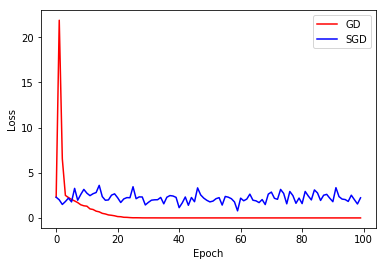

In [7]:
plt.plot(loss_list0,'red',label='GD')
plt.plot(loss_list1,'blue',label='SGD')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

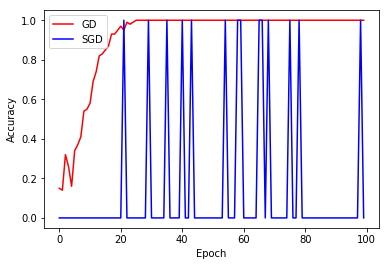

In [8]:
plt.plot(acc_list0,'red',label='GD')
plt.plot(acc_list1,'blue',label='SGD')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## 2.2 Train the network using SGD with Dropout
### Define the model with Dropout

In [9]:
class ConvNetWD(nn.Module):  #inherit from the nn.Module super class 
        def __init__(self):
            super(ConvNetWD, self).__init__() 
            #create some sequential layer objects within the class _init_ function
            self.layer1 = nn.Sequential(    
                #create sequentially ordered layers ( a convolution + ReLU + pooling )
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  #create a set of convolutional filters
                nn.ReLU(),  #ReLU activation
                nn.MaxPool2d(kernel_size=2, stride=2)  #downsample; padding argument defaults to 0
            )
            self.layer2 = nn.Sequential(
                #difference from layer1: he input into the Conv2d function is 32 channels, with an output of 64 channels
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)  )
            self.drop_out = nn.Dropout() #a drop-out layer to avoid over-fitting
            
            #Create 2 fully connected layers
                #The first argument to this method is the number of nodes in the layer
                #The second argument is the number of nodes in the following layer
            self.fc1 = nn.Linear(7 * 7 * 64, 1000) # 7 x 7 x 64 nodes; connect to the second layer of 1000 nodes
            self.fc2 = nn.Linear(1000, 10)

        #override the base forward function in nn.Module
            #x is the data that is to be passed through the model (i.e. a batch of data)
            #out is the output of each layer
        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)
            out = self.drop_out(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
        
        def backward(self, delta):
            n = len(self.__layers)

            for i in self.__layers[::-1]:
                delta = self.__layers[i].backward(delta)

            return

In [10]:
#parameters for SGD
num_epochs = 100
num_classes = 10
sample_size=100  #slower with larger sample_size
batch_size = 1
learning_rate = 0.01 #arbituary

#set the arguments
dataloader_args = dict(shuffle=False, batch_size=batch_size,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=False, batch_size=batch_size)
#load the train and test data as DataLoader objects
train_loader = dataloader.DataLoader(train, **dataloader_args,
                                    sampler= SubsetRandomSampler(np.random.RandomState(seed=0).randint(0,len(train)-1,sample_size).tolist())
                                    ) 
test_loader = dataloader.DataLoader(test, **dataloader_args)

### Implement and train the model with dropout

In [11]:
model = ConvNetWD() #an instance of our ConvNetWD class

#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss() #it combines both a SoftMax activation and a cross entropy loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                            #The first argument is the parameters we want the optimizer to train.
    
#the training loop
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):   #iterate over epochs
    for i, (images, labels) in enumerate(train_loader): #iterate over train_loader in each epoch
        # Run the forward pass
        outputs = model(images) #images is a batch of normalized MNIST images from train_loader
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())

        # perform back-propagation and optimization
        optimizer.zero_grad()  #make the initial gradients zero
        loss.backward()  #perform the back-propagation
        optimizer.step() #step() method updates the parameters

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
                #torch.max() determines the predictions of the model
                #it finds the maximum value over the 10 output nodes (handwritten digits 0-9)
                    # The first argument is the tensor to be examined
                    # The second argument is the  the dimension to reduce (1-the output node axis; 0-the batch_size dimension)
        correct = (predicted == labels).sum().item()
                # the output of sum() is still a tensor, so to access its value you need to call .item()
        #acc_list.append(correct / total)
    acc_list.append(correct / total)
    loss_list.append(loss.item())

### Plot the loss for SGD with and without dropout

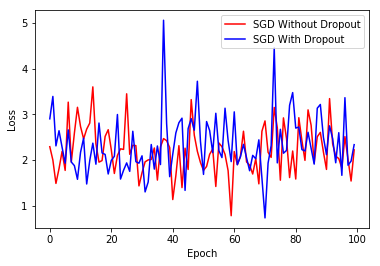

In [12]:
plt.plot(loss_list1,'red',label='SGD Without Dropout')
plt.plot(loss_list,'blue',label='SGD With Dropout')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

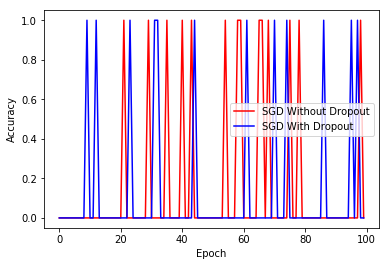

In [13]:
plt.plot(acc_list1,'red',label='SGD Without Dropout')
plt.plot(acc_list,'blue',label='SGD With Dropout')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## 2.1 Train the network using SGD with momentum = 0.9

In [14]:
model0 = ConvNetWOD() #an instance of our ConvNetWOD class

#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss() #it combines both a SoftMax activation and a cross entropy loss function
optimizer = torch.optim.SGD(model0.parameters(), lr=learning_rate,
                             momentum = 0.9 )  #set momentum
    
#the training loop
total_step = len(train_loader)
loss_list0 = []
acc_list0 = []
for epoch in range(num_epochs):   #iterate over epochs
    for i, (images, labels) in enumerate(train_loader): #iterate over train_loader in each epoch
        # Run the forward pass
        outputs = model0(images) #images is a batch of normalized MNIST images from train_loader
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())

        # perform back-propagation and optimization
        optimizer.zero_grad()  #make the initial gradients zero
        loss.backward()  #perform the back-propagation
        optimizer.step() #step() method updates the parameters

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
                #torch.max() determines the predictions of the model
                #it finds the maximum value over the 10 output nodes (handwritten digits 0-9)
                    # The first argument is the tensor to be examined
                    # The second argument is the  the dimension to reduce (1-the output node axis; 0-the batch_size dimension)
        correct = (predicted == labels).sum().item()
                # the output of sum() is still a tensor, so to access its value you need to call .item()
        #acc_list.append(correct / total)

    acc_list0.append(correct / total)
    loss_list0.append(loss.item())

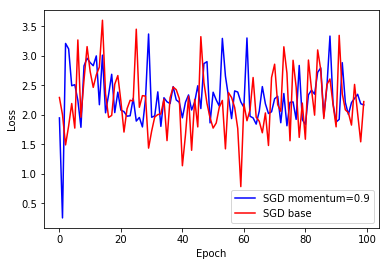

In [15]:
plt.plot(loss_list0,'blue',label='SGD momentum=0.9')
plt.plot(loss_list1,'red',label='SGD base')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

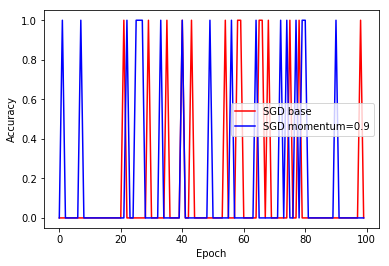

In [16]:
plt.plot(acc_list1,'red',label='SGD base')
plt.plot(acc_list0,'blue',label='SGD momentum=0.9')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## 2.3 Train the network using SGD with L2 regularization

In [17]:
model0 = ConvNetWOD() #an instance of our ConvNetWOD class

#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss() #it combines both a SoftMax activation and a cross entropy loss function
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate,
                            weight_decay=0.001 ) # decay is added directly to the update acording to L2 penalty rule
    
#the training loop
total_step = len(train_loader)
loss_list0 = []
acc_list0 = []
for epoch in range(num_epochs):   #iterate over epochs
    for i, (images, labels) in enumerate(train_loader): #iterate over train_loader in each epoch
        # Run the forward pass
        outputs = model0(images) #images is a batch of normalized MNIST images from train_loader
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())

        # perform back-propagation and optimization
        optimizer.zero_grad()  #make the initial gradients zero
        loss.backward()  #perform the back-propagation
        optimizer.step() #step() method updates the parameters

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) 
                #torch.max() determines the predictions of the model
                #it finds the maximum value over the 10 output nodes (handwritten digits 0-9)
                    # The first argument is the tensor to be examined
                    # The second argument is the  the dimension to reduce (1-the output node axis; 0-the batch_size dimension)
        correct = (predicted == labels).sum().item()
                # the output of sum() is still a tensor, so to access its value you need to call .item()
        #acc_list.append(correct / total)

    acc_list0.append(correct / total)
    loss_list0.append(loss.item())

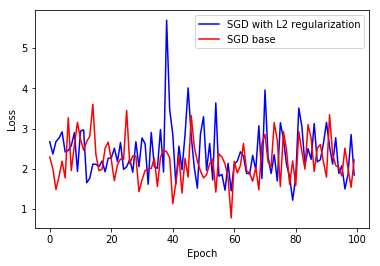

In [18]:
plt.plot(loss_list0,'blue',label='SGD with L2 regularization')
plt.plot(loss_list1,'red',label='SGD base')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

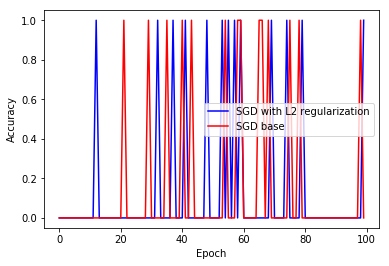

In [19]:
plt.plot(acc_list0,'blue',label='SGD with L2 regularization')
plt.plot(acc_list1,'red',label='SGD base')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()